# Dependency on errors in the lineage tree

- Check the dependency of the mean error on the number of permutated elements in the lineage cost matrix. 

## Preliminaries

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import scvelo as scv
import moscot as mt
import moscot.plotting as mtp
from anndata import AnnData
import matplotlib.colors as mcolors
import scipy.sparse as sp
from tqdm import tqdm
import seaborn as sns

import moslin_utils as mu
from moslin_utils.constants import DATA_DIR, FIG_DIR, TIME_KEY, TIMEPOINTS

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

Print the moscot version. 

In [3]:
mt.__version__

'0.3.5.dev36+g628bceb'

### Dependencies

This notebook depends on [ML_2024-03-11_prepare_data.ipynb](ML_2024-03-11_prepare_data.ipynb) and on [ML_2024-03-11_compute_couplings.ipynb](ML_2024-03-11_compute_couplings.ipynb). 

### Set up paths

Define the paths for data and figures

In [4]:
FIG_DIR = FIG_DIR / "packer_c_elegans" / "time_gap"
DATA_DIR = DATA_DIR / "packer_c_elegans"

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)

### Set global parameters

In [6]:
DPI_SAVE = 250

scv.settings.set_figure_params(
    "scvelo",
    dpi_save=DPI_SAVE,
    dpi=80,
    transparent=True,
    fontsize=20,
    color_map="viridis",
)
scv.settings.plot_prefix = ""

In [7]:
# should figures just be displayed or also saved?
save_figure = False
RANDOM_STATE = 0

In [8]:
LINEAGE_INFO = "complete"
random_state = 0

### Define utility functions

In [9]:
def hex_to_rgb(hex_color):
    """Convert a hex color to an RGB tuple."""
    hex_color = hex_color.lstrip("#")  # Remove '#' if present
    return tuple(int(hex_color[i : i + 2], 16) for i in (0, 2, 4))


def rgb_to_hex(rgb_color):
    """Convert an RGB tuple back to a hex color."""
    return "#{:02x}{:02x}{:02x}".format(*rgb_color)


def average_hex_color(hex_color1, hex_color2):
    """Calculate the average of two hex colors."""
    rgb1 = hex_to_rgb(hex_color1)
    rgb2 = hex_to_rgb(hex_color2)
    avg_rgb = tuple((c1 + c2) // 2 for c1, c2 in zip(rgb1, rgb2))
    return rgb_to_hex(avg_rgb)

### Load and preprocess the data

Load AnnData objects, created in previous notebooks. 

In [10]:
# import the raw data, to re-compute the couplings
adata = sc.read(DATA_DIR / "ML_2024-06-09_c_elegans_prep.h5ad")
adata

AnnData object with n_obs × n_vars = 46151 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'subset', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'assigned_batch_time_colors', 'cell.type_colors', 'clusters_colors', 'coarse_clusters_colors', 'subset_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_abpxp'

Download the C. elegans lineage tree [(Packer et al., Science 2019)](https://www.science.org/doi/10.1126/science.aax1971) from [figshare](https://doi.org/10.6084/m9.figshare.c.6533377.v1). Subset to the ABpxp lineage, preprocess the data, compute PCA, and write the lineage tree to `.uns`. 

In [11]:
_, full_reference_tree = mt.datasets.c_elegans(DATA_DIR / "c_elegans")

In addition, import the grid search results to inform our choice of hyperparematers. The results of our gridsearch are included in this repositroy in `data/packer_c_elegans`. 

In [12]:
grid_df = pd.read_csv(DATA_DIR / "ML_2024-06-05_celegans_precise_and_abpxp.csv", index_col=0)

Subset the anndata object. 

In [13]:
mask = adata.obs["subset"] == LINEAGE_INFO
adata = adata[mask].copy()
adata

AnnData object with n_obs × n_vars = 5123 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'subset', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF'
    uns: 'assigned_batch_time_colors', 'cell.type_colors', 'clusters_colors', 'coarse_clusters_colors', 'subset_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_abpxp'

Preprocess

In [14]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.pca(adata)

Create lineage trees

In [15]:
rng = np.random.RandomState(RANDOM_STATE)
trees = {}
for batch_time in adata.obs[TIME_KEY].cat.categories:
    print(f"Creating tree for batch time {batch_time}")
    seed = rng.randint(0, 2**16 - 1)
    trees[batch_time] = mu.ul.create_lineage_tree(
        adata, batch_time=batch_time, reference_tree=full_reference_tree, seed=seed
    )

adata.uns["trees"] = trees

Creating tree for batch time 130
Creating tree for batch time 170
Creating tree for batch time 210
Creating tree for batch time 270
Creating tree for batch time 330
Creating tree for batch time 390
Creating tree for batch time 450
Creating tree for batch time 510
Creating tree for batch time 580
Creating tree for batch time 650
Creating tree for batch time 75
Creating tree for batch time 700


In addition, import the grid search results to inform our choice of hyperparematers. The results of our gridsearch are included in this repositroy in `data/packer_c_elegans`. 

In [16]:
grid_df = pd.read_csv(DATA_DIR / "ML_2024-06-05_celegans_precise_and_abpxp.csv", index_col=0)

### Visualize in an embedding

For convenience, rename the UMAP. 

In [17]:
adata.obsm["X_umap"] = adata.obsm["X_umap_abpxp"].copy()

Rearrange the order in which clusters appear

In [18]:
adata = mu.ul.sort_clusters(adata)

Show in the UMAP. 

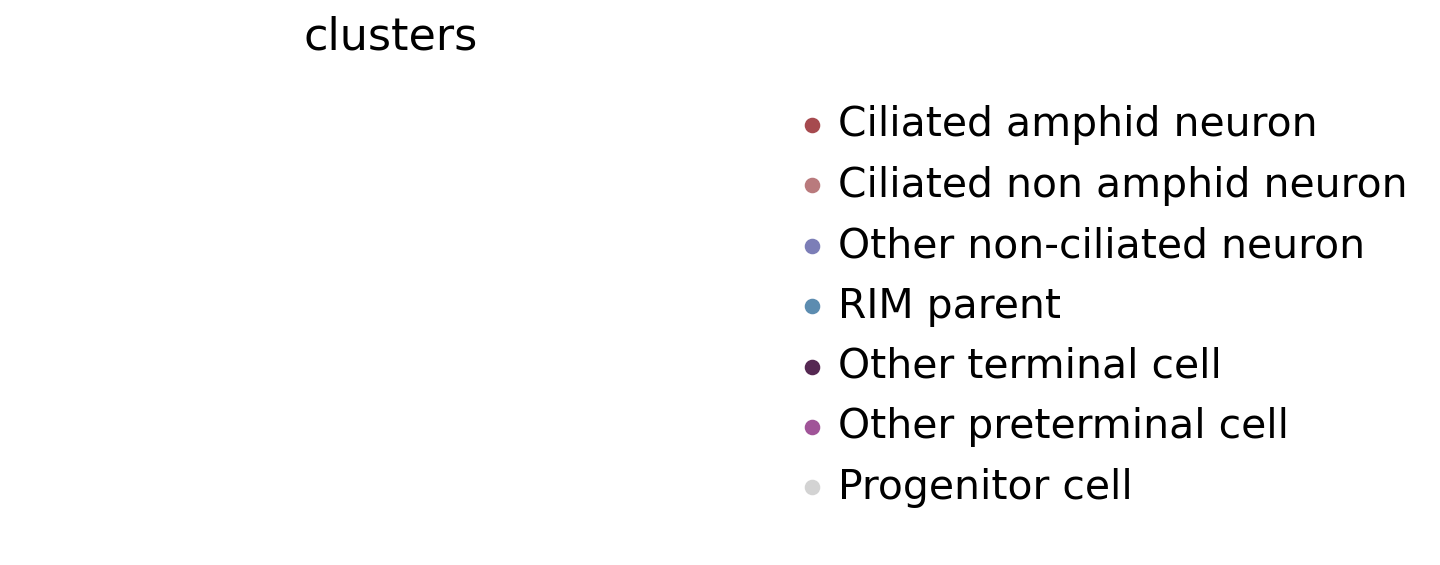

In [19]:
scv.pl.scatter(adata, c=["clusters"], legend_loc="right")

## Compute the couplings

Subset to the relevant timepoints. 

In [20]:
adata = adata[adata.obs[TIME_KEY].isin(TIMEPOINTS)].copy()
adata.uns[f"{TIME_KEY}_colors"] = [
    mcolors.to_hex(c) for c in plt.get_cmap("gnuplot")(np.linspace(0, 1, len(TIMEPOINTS)))
]

adata

AnnData object with n_obs × n_vars = 5097 × 20222
    obs: 'idx', 'barcode', 'n.umi', 'time.point', 'batch', 'Size_Factor', 'cell.type', 'cell.subtype', 'plot.cell.type', 'raw.embryo.time', 'embryo.time', 'embryo.time.bin', 'raw.embryo.time.bin', 'lineage', 'passed_initial_QC_or_later_whitelisted', 'random_precise_lineage', 'assigned_batch_time', 'subset', 'clusters', 'coarse_clusters'
    var: 'Ensembl', 'gene_short_name', 'Symbol', 'Family', 'Protein', 'Entrez_ID', 'TF', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'assigned_batch_time_colors', 'cell.type_colors', 'clusters_colors', 'coarse_clusters_colors', 'subset_colors', 'log1p', 'hvg', 'pca', 'trees'
    obsm: 'X_pca', 'X_umap', 'X_umap_abpxp'
    varm: 'PCs'

Query hyperparameters

In [26]:
if LINEAGE_INFO == "complete":
    lineage_info_query = "precise"
else:
    lineage_info_query = LINEAGE_INFO

hyper_df = mu.ul.get_best_runs(
    df=grid_df, lineage_info=lineage_info_query, group_key="kind", group="moslin", converged=True
)

# set some other parameters manually
tau_a = 1.0
timepoint_pairs = [(170, 210), (450, 510)]

Removing 19/240 not converged runs.


Loop over different percentages over information to perturb. 

In [28]:
# initialize a dict to store the results
results = {}
i = 0

for timepoint_pair in timepoint_pairs:
    early_tp, late_tp = timepoint_pair[0], timepoint_pair[1]

    # extract hyperparameters from gridsearch results
    params = hyper_df.loc[hyper_df["tp"] == f"{early_tp}-{late_tp}"]
    alpha = params["alpha"].values[0]
    epsilon = params["epsilon"].values[0]
    scale_cost = params["scale_cost"].values[0]
    max_inner_iterations = params["max_inner_iterations"].values[0]

    print(f"{early_tp=}, {late_tp=}, {epsilon=}, {alpha=} {scale_cost=} {max_inner_iterations=}")

    # compute the ground-truth coupling and cost-matrices
    gt_coupling, early_dist, late_dist, bdata = mu.tl.prepare_moscot(
        adata=adata,
        early_time=early_tp,
        late_time=late_tp,
        reorder_clusters=True,
    )

    # write marginals to bdata
    bdata.obs["marginals"] = np.r_[gt_coupling.early_marginal, gt_coupling.late_marginal]

    # loop over cost-matrix perturbation percentages
    for x_percent in tqdm(np.linspace(0, 100, num=15), desc="Processing"):
        # perturb cost matrix elements
        np.random.seed(random_state)
        early_dist_perturbed, percent_perturbed_early = mu.ul.permute_symmetric_matrix_elements(
            early_dist, x_percent=x_percent
        )
        late_dist_perturbed, percent_perturbed_late = mu.ul.permute_symmetric_matrix_elements(
            late_dist, x_percent=x_percent
        )

        # write cost matrices to bdata
        bdata.obsp["cost_matrices"] = sp.bmat([[early_dist_perturbed, None], [None, late_dist_perturbed]], format="csr")

        # initialize a lineage problem
        prob = mt.problems.time.LineageProblem(bdata)

        # prepare the lineage problem
        prob = prob.prepare(
            time_key=TIME_KEY,
            joint_attr={"attr": "obsm", "key": "X_pca"},
            lineage_attr={"attr": "obsp", "key": "cost_matrices", "cost": "custom"},
            a="marginals",
            b="marginals",
        )

        # solve the lineage problem
        prob = prob.solve(
            epsilon=epsilon,
            alpha=alpha,
            tau_a=tau_a,
            tau_b=1.0,
            scale_cost=scale_cost,
            store_inner_errors=False,
            max_iterations=50,
            min_iterations=5,
            linear_solver_kwargs={"max_iterations": max_inner_iterations},
            threshold=1e-3,
        )

        # quantify predictive performance by computing the mearn error
        pred = np.asarray(prob.solutions[early_tp, late_tp].transport_matrix)

        early_cost = gt_coupling.cost(pred, late=False)
        late_cost = gt_coupling.cost(pred, late=True)
        mean_error = (early_cost + late_cost) / 2

        # write to dict
        results[i] = {
            "susbset": LINEAGE_INFO,
            "target_percent_perturbed": x_percent,
            "timepoint_pair": f"{early_tp}-{late_tp}",
            "percent_perturbed_early": percent_perturbed_early,
            "percent_perturbed_late": percent_perturbed_late,
            "percent_perturbed_average": (percent_perturbed_early + percent_perturbed_late) / 2,
            "mean_error": mean_error,
        }

        # increase the iteration counter
        i += 1

early_tp=170, late_tp=210, epsilon=0.01, alpha=0.98 scale_cost='mean' max_inner_iterations=30000.0


Processing:   0%|          | 0/15 [00:00<?, ?it/s]

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.6542617242709667e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.2890086520389588e-07
  warnings.warn(("

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.5692785382270813e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.1714291781039776e-07
  warnings.warn(("

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.103617252029565e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -3.736931841746838e-08
  warnings.warn(("Ex

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -8.242204774244755e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
Processing:  27%|██▋       | 4/15 [00:18<00:43,  3.97s/it]

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.9604340195655823e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.0308576758877308e-07
  warnings.warn(("

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.3562385003940136e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -5.7392753660678864e-08
  warnings.warn(("

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -4.3422915041446686e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.9179424382009813e-08
  warnings.warn(("

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -4.435423772708447e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -3.2334355637431145e-08
  warnings.warn(("E

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -5.6694261729717255e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -5.0815287866434744e-08
  warnings.warn(("

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 2.9569491744041443e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 3.675813786685467e-08
  warnings.warn(("Exp

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -6.55418261885643e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -7.209018804132938e-08
  warnings.warn(("Exp

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.8044374883174896e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -2.025626610890896e-08
  warnings.warn(("E

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -3.096647571698696e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -3.5273842735605854e-08
  warnings.warn(("E

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -4.3306499830642053e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -3.16067598760128e-08
  warnings.warn(("Ex

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(151, 531)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.1641532182693481e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -9.886571195050209e-08
  warnings.warn(("E

early_tp=450, late_tp=510, epsilon=0.01, alpha=0.98 scale_cost='mean' max_inner_iterations=30000.0


Processing:   0%|          | 0/15 [00:00<?, ?it/s]

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.4435499895437687e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 1.1961674317717552e-08
  warnings.warn(("E

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -2.407468856491235e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
Processing:  13%|█▎        | 2/15 [00:11<01:12,  5.56s/it]

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -4.400499166168359e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -8.94651748239994e-08
  warnings.warn(("Exp

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -2.0675361178668084e-07
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -9.627547103985279e-08
  warnings.warn(("E

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -3.119930636064083e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
Processing:  33%|███▎      | 5/15 [00:23<00:41,  4.18s/it]

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 1.7549609765410423e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
Processing:  40%|████      | 6/15 [00:27<00:36,  4.03s/it]

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 4.14438547924334e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 6.079790182411671e-08
  warnings.warn(("Expan

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 5.5413693411665577e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 5.454057827591896e-08
  warnings.warn(("Exp

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -3.3993273973464966e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -1.4726538211107254e-08
  warnings.warn(("

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 5.168840311320366e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 3.605964593589306e-08
  warnings.warn(("Expa

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -6.612390268667667e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -4.4674379751086235e-08
  warnings.warn(("E

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 8.940696716308594e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 6.263144314289093e-08
  warnings.warn(("Expa

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 1.100124791264534e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
Processing:  87%|████████▋ | 13/15 [00:53<00:07,  3.89s/it]

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -2.887099959103523e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: -4.275352694094181e-08
  warnings.warn(("Ex

WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
WARNING  Densifying data in `adata.obsp['cost_matrices']`                                                          
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(461, 201)].                                    


/cluster/project/treutlein/USERS/mlange/mambaforge/envs/moslin_3/lib/python3.11/site-packages/lineageot/evaluation.py:159: UserWarning: Expanded coupling not computed correctly. Check for infeasibility in row and column OT calculations. Updating the python optimal transport package may help (https://github.com/PythonOT/POT/issues/93).
If total mass - 1 is small, this may not significantly affect downstream results.
Total mass - 1: 3.559398464858532e-08
  warnings.warn(("Expanded coupling not computed correctly. " +
Processing: 100%|██████████| 15/15 [01:01<00:00,  4.12s/it]


### Visualize results

Transform this into a DataFrame

In [29]:
results_df = pd.DataFrame(results).T
results_df

,susbset,target_percent_perturbed,timepoint_pair,percent_perturbed_early,percent_perturbed_late,percent_perturbed_average,mean_error
0,complete,0.0,170-210,0.0,0.0,0.0,0.127273
1,complete,7.142857,170-210,5.395143,5.420176,5.40766,0.132442
2,complete,14.285714,170-210,10.675497,10.820453,10.747975,0.138387
3,complete,21.428571,170-210,16.1766,16.249156,16.212878,0.148621
4,complete,28.571429,170-210,22.110375,21.557048,21.833712,0.153995
5,complete,35.714286,170-210,26.887417,27.025548,26.956483,0.178914
6,complete,42.857143,170-210,33.165563,32.516079,32.840821,0.21015
7,complete,50.0,170-210,38.322296,37.870163,38.096229,0.236915
8,complete,57.142857,170-210,43.682119,43.260491,43.471305,0.277318
9,complete,64.285714,170-210,49.236203,48.714067,48.975135,0.335614


Let's visualize the mean error as a function of the percentage of perturbed elements. 

In [30]:
color_dict = {tp: color for tp, color in zip(adata.obs[TIME_KEY].cat.categories, adata.uns[f"{TIME_KEY}_colors"])}
color_map = {
    f"{tp_early}-{tp_late}": average_hex_color(color_dict[tp_early], color_dict[tp_late])
    for tp_early, tp_late in zip(color_dict.keys(), list(color_dict.keys())[1:])
}
color_map

{'170-210': '#33006d',
 '210-270': '#7d05dc',
 '270-330': '#a4146e',
 '330-390': '#c23600',
 '390-450': '#dc7000',
 '450-510': '#f4ca00'}

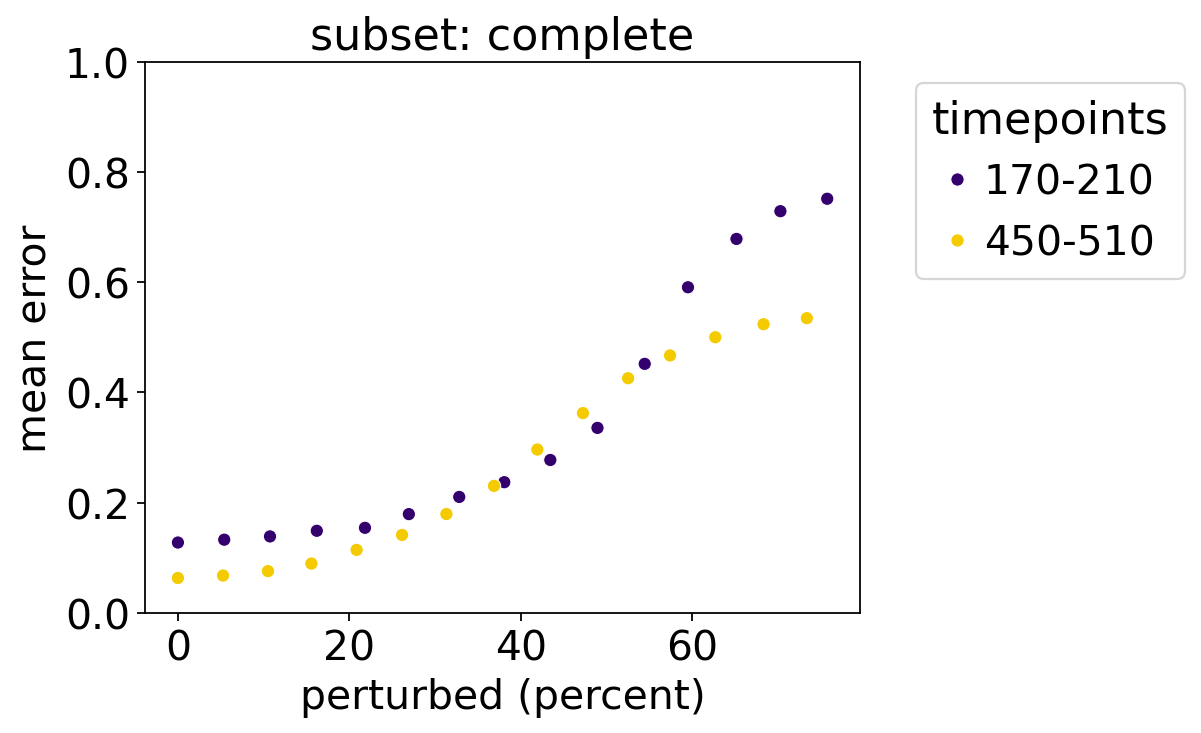

In [31]:
# Set the figure size to make the plot wider, e.g., 10 inches wide by 6 inches tall
plt.figure(figsize=(8, 5))

sns.scatterplot(data=results_df, x="percent_perturbed_average", y="mean_error", hue="timepoint_pair", palette=color_map)

plt.title(f"subset: {LINEAGE_INFO}")
plt.xlabel("perturbed (percent)")
plt.ylabel("mean error")
plt.ylim(0, 1)

# Move the legend outside the plotting area
plt.legend(title="timepoints", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()